In [29]:
import ast
import csv
from distutils.log import error 
import matplotlib.pyplot as plt
import json
import math
import numpy as np

import led_config_utils
from funky_lights import wavefront, led_config


class Segment:
    def __init__(self, start, end):
        self.start = start
        self.start_str = '{:.3f}, {:.3f}, {:.3f}'.format(
            start[0], start[1], start[2])
        self.end = end
        self.end_str = '{:.3f}, {:.3f}, {:.3f}'.format(
            end[0], end[1], end[2])

    def flip(self):
        self.start, self.end = self.end, self.start
        self.start_str, self.end_str = self.end_str, self.start_str

    def __repr__(self):
        return repr([self.start, self.end])


class Polygon:
    def __init__(self, segments=[]):
        self.vertices = []
        for segment in segments:
            self.vertices.append(segment.start)

    def __repr__(self):
        return repr(self.vertices)


def prepare_data(polygons):
    x = np.array([v[0] for v in p.vertices for p in polygons])
    y = np.array([v[1] for v in p.vertices for p in polygons])
    z = np.array([v[2] for v in p.vertices for p in polygons])

    data = np.concatenate((x[:, np.newaxis],
                           y[:, np.newaxis],
                           z[:, np.newaxis]),
                           axis=1)
    return data

def project_polygons_2d(polygons):
    data = prepare_data(polygons)
    Z, U, mu = led_config_utils.pca(data)
    polygons_2d = []
    for p in polygons:
        polygon_2d = Polygon()
        for v in p.vertices:
            L = np.dot(v - mu, U.T)
            vertex_2d = np.array([L.T[0], L.T[1]])
            polygon_2d.vertices.append(vertex_2d)
        polygons_2d.append(polygon_2d)
    return polygons_2d

def read_line_segments(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # skip header

        segments = []
        for row in reader:
            uid = int(row[0])
            name = row[1]
            actual_num_leds = int(row[2])
            actual_length = float(row[3])
            reverse = (row[4] == 'TRUE')
            led_offset = int(row[5])
            sub_component = row[6]
            actual_num_adressable_leds = int(row[7])
            csv_points = ast.literal_eval(row[10])
            
            segment_points = []
            for p in csv_points:
                point = np.array(p)
                point = (point.reshape((3,1))).reshape((1,3))
                point = np.squeeze(np.asarray(point))
                segment_points.append(p)
            segments.append(segment_points)
    
    return segments

def create_polygons_from_segments(segments):
    start_dict = {}
    end_dict = {}
    for segment_points in segments:
        segment = Segment(segment_points[0], segment_points[1])
        if segment.start_str in start_dict:
            segment2 = start_dict[segment.start_str]
            if segment.end_str == segment2.end_str:
                print(
                    f"Ignoring duplicate line segment [[{segment.start_str}], [{segment.end_str}]]")
                continue
            else:
                segment = Segment(segment_points[1], segment_points[0])
                print(
                    f"Flipping line segment [[{segment.start_str}], [{segment.end_str}]]")
        if segment.end_str in end_dict:
            segment2 = end_dict[segment.end_str]
            if segment.start_str == segment2.start_str:
                print(
                    f"Ignoring duplicate line segment [[{segment.start_str}], [{segment.end_str}]]")
                continue
            else:
                segment = Segment(segment_points[1], segment_points[0])
                print(
                    f"Flipping line segment [[{segment.start_str}], [{segment.end_str}]]")
        start_dict[segment.start_str] = segment
        end_dict[segment.end_str] = segment


    polygons = []
    while start_dict:
        polygon_segments = []
        polygon_start_str, segment = start_dict.popitem()
        end_str = '%s' % segment.end_str
        end_dict.pop(end_str)
        polygon_segments.append(segment)
        while end_str != polygon_start_str:
            if end_str in start_dict:
                segment = start_dict.pop(end_str)
                end_str = '%s' % segment.end_str
                end_dict.pop(end_str)
                polygon_segments.append(segment)
            elif end_str in end_dict:
                segment = end_dict.pop(end_str)
                start_dict.pop(segment.start_str)
                segment = Segment(segment.end, segment.start)
                end_str = '%s' % segment.end_str
                polygon_segments.append(segment)
            else:
                print(
                    f"Couldn't find line segment {end_str} to finish polygon.")
                break
        # print(len(polygon_segments))
        polygons.append(Polygon(polygon_segments))

    return polygons
        

for face in ['face_front', 'face_front_right', 'face_front_left']:
# for face in ['face_front']:
    print(f'Processing {face}')
    segments = read_line_segments(f'../config/{face}_polygon_line_segments.csv')
    polygons = create_polygons_from_segments(segments)
    polygons_2d = project_polygons_2d(polygons)

    with open(f'../config/{face}_polygons.csv', 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        for p in polygons:
            writer.writerow([repr(p)])

# # print(polygons)
# for p in polygons:
#     print(len(p))
#     for s in p:
#         print(f"  {s.start_str}, {s.end_str}")

Processing face_front
Flipping line segment [[-0.112, 1.271, 0.489], [-0.096, 1.296, 0.485]]
Flipping line segment [[0.112, 1.271, 0.489], [0.096, 1.296, 0.485]]
Flipping line segment [[-0.332, 0.465, 0.632], [-0.340, 0.465, 0.632]]
Flipping line segment [[0.332, 0.465, 0.632], [0.340, 0.465, 0.632]]


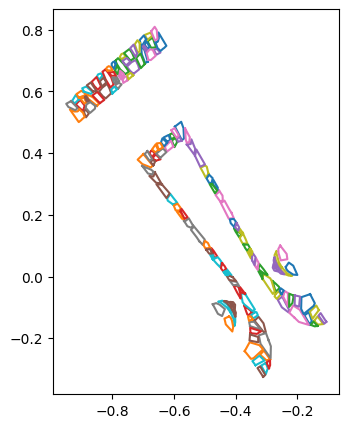

In [32]:
def plot_polygons_2d(polygons_2d):
    
    # create scatter plot for samples from each cluster
    for polygon in polygons_2d:
        x = [v[0] for v in polygon.vertices] + [polygon.vertices[0][0]]
        y = [v[1] for v in polygon.vertices] + [polygon.vertices[0][1]]
        plt.plot(x, y)

    plt.axis('scaled')
    plt.show()
    plt.rcParams['figure.figsize'] = [25, 5]


plot_polygons_2d(polygons_2d)